In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sqlite3
import os
import re
%matplotlib inline

# Import and Preprocess 

In [66]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\testname\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\testname\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\testname\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\testname\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\testname\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Revised import function

Using NLTK for parsing has improved the results of POS tagging. We do this for 10 different texts.

In [67]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [68]:
"""
NOTE: NLTK tokenization messes up whitespace and 
handles non-alpha characters differently.
"""

def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [104]:
# src_file_name = '2701-0.txt'
# src_file_url = 'https://www.gutenberg.org/files/2701/2701-0.txt'

K_list = []
V_list = []

src_file_names = [
                 'corpus/a_tale_of_two_cities.txt',
                 'corpus/anna_karenina.txt',
                 'corpus/captains_courageous.txt',
                 'corpus/emma.txt',
                 'corpus/far_from_madding_crowd.txt',
                 'corpus/heart_of_darkness.txt',
                 'corpus/jane_eyre.txt',
                 'corpus/pride_and_prejudice.txt',
                 'corpus/portrait_of_a_lady_vol1.txt',
                 'corpus/portrait_of_a_lady_vol2.txt'
                 ]

db_file_names = [
                 'db/a_tale_of_two_cities.db',
                 'db/anna_karenina.db',
                 'db/captains_courageous.db',
                 'db/emma.db',
                 'db/far_from_madding_crowd.db',
                 'db/heart_of_darkness.db',
                 'db/jane_eyre.db',
                 'db/pride_and_prejudice.db',
                 'db/portrait_of_a_lady_vol1.db',
                 'db/portrait_of_a_lady_vol2.db'
                 ]
body_starts = [
               111, # a tale of 2 cities
               61, # anna karenina
               38, # captains courageous
               43, # emma
               112, # far from madding crowd
               38, # heart of darkness
               72, # jane eyre
               98, # pride and predjudice
               43, # portrait of a lady (vol 1)
               43 # portrait of a lady (vol 2)
               ]
body_ends = [
            15900, # a tale of 2 cities
            39892, # anna karenina
            6185, # captains courageous
            16262, # emma
            17196, # far from madding crowd
            3343, # heart of darkness
            20700, # jane eyre
            13339, # pride and predjudice
            12879, # portrait of a lady (vol 1)
            12221 # portrait of a lady (vol 2)
            ]
chap_pats = [
            r'^\s*(?:CHAPTER).*$', # a tale of 2 cities
            r'^\s*(?:Chapter|ETYMOLOGY|Epilogue).*$', # anna karenina
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # captains courageous
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # emma
            r'^\s*(?:CHAPTER|PREFACE).*$', # far from madding crowd
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # heart of darkness
            r'^\s*(?:CHAPTER|PREFACE|Epilogue).*$', # jane eyre
            r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$', # pride and predjudice
            r'^\s*(?:CHAPTER|PREFACE|Epilogue).*$', # portrait of a lady (vol 1)
            r'^\s*(?:CHAPTER|PREFACE|Epilogue).*$' # portrait of a lady (vol 2)
            ]

In [105]:
for s in range(0,len(src_file_names)):
    print('iteration %d' % s)
    print('src_file_name %s' % src_file_names[s])
    print('body_start %d' % body_starts[s])
    print('body_end %d' % body_ends[s])
    print('chap_pat %s' % chap_pats[s])
    cfg = dict(
        src_file = src_file_names[s],
        body_start = body_starts[s],
        body_end = body_ends[s],
        chap_pat = chap_pats[s]
    )
    print(cfg)
#     cfg2 = dict(
#         src_file = '2701-0.txt',
#         body_start = 341,
#         body_end = 21964,
#         chap_pat = r'^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'
#     )
#     print(cfg2)

    K, V = text_to_tokens(**cfg)
    K_list.append(K)
    V_list.append(V)
    K_list[s].head()
    V_list[s].head()

iteration 0
src_file_name corpus/a_tale_of_two_cities.txt
body_start 111
body_end 15900
chap_pat ^\s*(?:CHAPTER).*$
{'src_file': 'corpus/a_tale_of_two_cities.txt', 'body_start': 111, 'body_end': 15900, 'chap_pat': '^\\s*(?:CHAPTER).*$'}
iteration 1
src_file_name corpus/anna_karenina.txt
body_start 61
body_end 39892
chap_pat ^\s*(?:Chapter|ETYMOLOGY|Epilogue).*$
{'src_file': 'corpus/anna_karenina.txt', 'body_start': 61, 'body_end': 39892, 'chap_pat': '^\\s*(?:Chapter|ETYMOLOGY|Epilogue).*$'}
iteration 2
src_file_name corpus/captains_courageous.txt
body_start 38
body_end 6185
chap_pat ^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$
{'src_file': 'corpus/captains_courageous.txt', 'body_start': 38, 'body_end': 6185, 'chap_pat': '^\\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$'}
iteration 3
src_file_name corpus/emma.txt
body_start 43
body_end 16262
chap_pat ^\s*(?:CHAPTER|ETYMOLOGY|Epilogue).*$
{'src_file': 'corpus/emma.txt', 'body_start': 43, 'body_end': 16262, 'chap_pat': '^\\s*(?:CHAPTER|ETYMOLOGY|Epilogue)

## Test to see if 'and' is annotated properly

In [74]:
K_list[0][K_list[0].term_str=='and'].pos

chap_num  para_num  sent_num  token_num
0         2         0         12           CC
                    1         7            CC
          3         0         10           CC
          4         1         4            CC
          5         2         0            CC
          8         0         9            CC
                              30           CC
                    3         43           CC
                              51           CC
          9         1         18           CC
                              40           CC
                              48           CC
                              54           CC
                              63           CC
                              67           CC
                    3         8            CC
                    4         5            CC
                              33           CC
                              44           CC
          11        0         1            CC
          15        0         11        

In [75]:
K_list[0][(K_list[0].term_str=='and') & K_list[0].pos.isna()]

,,,,pos,token_str,punc,num,term_str,term_id
chap_num,para_num,sent_num,token_num,,,,,,


# Create DTM

## Create word mask and Extract BOW from tokens

In [106]:
for s in range(0,len(src_file_names)):
    WORDS[s] = (K_list[s].punc == 0) & (K_list[s].num == 0) & K_list[s].term_id.isin(V_list[s][V_list[s].stop==0].index)
    BOW[s] = K_list[s][WORDS[s]].groupby(CHAPS+['term_id'])['term_id'].count() # number of occurrences of word per chapter
    
    # Converting BOW to DTM
    DTM[s] = BOW[s].unstack().fillna(0)
    print(DTM[s].head())
    print("---------------------------------------------------------------------------------------------------")

ValueError: setting an array element with a sequence.

# Compute Term Frequencies and Weights

## Compute TF

In [81]:
alpha = .000001 # We introduce an arbitrary smoothing value, prevents divide-by-0 later on

for s in range(0,len(src_file_names)):
    alpha_sum[s] = alpha * V[s].shape[0]
    TF[s] = DTM[s].apply(lambda x: (x + alpha) / (x.sum() + alpha_sum[s]), axis=1)
    
    # Computing TFIDF
    N_docs[s] = DTM[s].shape[0]
    V[s]['df'] = DTM[s][DTM[s] > 0].count()
    TFIDF[s] = TF[s] * np.log2(N_docs[s] / V[s][V[s].stop==0]['df'])
    print(TFIDF[s].head())
    print("---------------------------------------------------------------------------------------------------")

## Compute TFIDF

In [85]:
# TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,3.059714e-09,2.766207e-09,2.396431e-09,3.561469e-09,3.059714e-09,3.059714e-09,3.561469e-09,3.059714e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,5.693736e-09,5.147562e-03,4.459451e-09,6.627437e-09,5.693736e-09,5.693736e-09,6.627437e-09,5.693736e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,8.481185e-09,7.667615e-09,6.642638e-09,9.871992e-09,8.481185e-09,8.481185e-09,9.871992e-09,8.481185e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.154776e-09,1.948076e-09,1.687665e-09,2.508132e-09,2.154776e-09,2.154776e-09,2.508132e-09,2.154776e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,7.709200e-09,6.969684e-09,6.038004e-09,8.973412e-09,7.709200e-09,7.709200e-09,8.973412e-09,7.709200e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute TFTH (Experiment)

In [86]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1) # term frequency, term entropy

In [87]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,16935,16936,16937,16938,16939,16940,16941,16942,16943,16944
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.211261e-11,5.621768e-12,2.023605e-11,3.792280e-11,6.519236e-12,8.523245e-12,1.646797e-11,7.500947e-12,1.361399e-11,2.292876e-12,...,9.155135e-12,3.659886e-11,6.467716e-12,3.043310e-11,3.892717e-12,4.511044e-12,5.806776e-12,6.430075e-12,2.763696e-06,2.763696e-06
1,2.254001e-11,1.046139e-11,3.765674e-05,7.056948e-11,1.213146e-11,1.586067e-11,3.064479e-11,1.395830e-11,2.533389e-11,4.266749e-12,...,1.703653e-11,6.810579e-11,1.203559e-11,5.663211e-11,7.243847e-12,8.394476e-12,1.080567e-11,1.196555e-11,5.142879e-12,5.142879e-12
2,3.357479e-11,1.558291e-11,5.609207e-11,1.051178e-10,1.807059e-11,2.362548e-11,4.564738e-11,2.079178e-11,3.773646e-11,6.355596e-12,...,2.537701e-11,1.014479e-10,1.792778e-11,8.435716e-11,1.079017e-11,1.250411e-11,1.609573e-11,1.782345e-11,7.660648e-12,7.660648e-12
3,8.530196e-12,3.959080e-12,1.425106e-11,2.670679e-11,4.591113e-12,6.002419e-12,1.159742e-11,5.282475e-12,9.587531e-12,1.614738e-12,...,6.447421e-12,2.577442e-11,4.554831e-12,2.143224e-11,2.741411e-12,3.176863e-12,4.089370e-12,4.528323e-12,1.946306e-12,1.946306e-12
4,3.051871e-11,1.416450e-11,5.098639e-11,9.554960e-11,1.642575e-11,2.147501e-11,4.149241e-11,1.889925e-11,3.430156e-11,5.777089e-12,...,2.306711e-11,9.221381e-11,1.629594e-11,7.667870e-11,9.808018e-12,1.136595e-11,1.463065e-11,1.620110e-11,6.963351e-12,6.963351e-12


## Add stats to V

In [88]:
V_list[0]['tf_sum'] = TF.sum()
V_list[0]['tf_mean'] = TF.mean()
V_list[0]['tf_max'] = TF.max()
V_list[0]['tfidf_sum'] = TFIDF.sum()
V_list[0]['tfidf_mean'] = TFIDF.mean()
V_list[0]['tfidf_max'] = TFIDF.max()
V_list[0]['tfth_sum'] = TFTH.sum()
V_list[0]['tfth_mean'] = TFTH.mean()
V_list[0]['tfth_max'] = TFTH.max()
V_list[0]['th_sum'] = THM.sum()
V_list[0]['th_mean'] = THM.mean()
V_list[0]['th_max'] = THM.max()

In [89]:
# cols = ['{}_{}'.format(i,j) 
#         for i in ['tf','tfidf','tfth'] 
#         for j in ['sum','mean','max']]
# V[cols].scatter_matrix()

## Discussion

* Why do we add summary statistics to the vocabulary table?

# Find Significant Words

In [90]:
TOPS_list = []
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        TOPS = pd.DataFrame(index=range(10))
        key = '{}_{}'.format(m,n)
        TOPS[key] = V_list[0].sort_values(key, ascending=False).term_str.head(10).tolist()
        TOPS_list.append(TOPS)

In [91]:
for s in range(0, len(TOPS_list)):
    print(len(TOPS_list))
    print('Book: %s' % src_file_names[int(s/2)])
    display(TOPS_list[s]) # tf-idf = term frequency–inverse document frequency

8
Book: 2701-0.txt


,tf_mean
0,whale
1,one
2,like
3,upon
4,man
5,ahab
6,ye
7,ship
8,would
9,sea


8
Book: 2701-0.txt


,tf_max
0,um
1,thunder
2,oil
3,rum
4,want
5,ye
6,fish
7,pipe
8,sir
9,ha


8
Book: corpus/a_tale_of_two_cities.txt


,tfidf_mean
0,ahab
1,boat
2,captain
3,flask
4,bildad
5,aye
6,coffin
7,deck
8,ha
9,fish


8
Book: corpus/a_tale_of_two_cities.txt


,tfidf_max
0,bucket
1,bulkington
2,cough
3,ha
4,ginger
5,coronation
6,fa
7,cabaco
8,chowder
9,harem


8
Book: corpus/anna_karenina.txt


,tfth_mean
0,whale
1,one
2,like
3,upon
4,man
5,ahab
6,would
7,ship
8,sea
9,old


8
Book: corpus/anna_karenina.txt


,tfth_max
0,whale
1,one
2,ye
3,um
4,ahab
5,man
6,like
7,sea
8,upon
9,thunder


8
Book: corpus/captains_courageous.txt


,th_mean
0,whale
1,one
2,like
3,upon
4,man
5,would
6,ship
7,ahab
8,sea
9,old


8
Book: corpus/captains_courageous.txt


,th_max
0,um
1,thunder
2,oil
3,rum
4,want
5,ye
6,fish
7,pipe
8,sir
9,ha


# Compare Chapters

## Create Docs table

In [92]:
# Get all docpairs
D = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [93]:
D.head()

,term_count,tf
chap_num,,
0,1993,0.018051
1,1071,0.009700
2,719,0.006512
3,2830,0.025632
4,791,0.007164


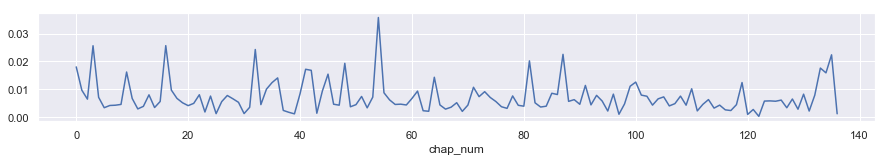

In [94]:
D.tf.plot(figsize=(15,2))

## Get all doc pairs

In [95]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [96]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [97]:
P.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

## Compute Euclidean distance

In [98]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [99]:
P['euclidean'] = 0

In [100]:
P['euclidean'] = P.apply(euclidean, 1)

In [101]:
PME = P.euclidean.unstack().fillna(0)

In [102]:
PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.101552,0.138396,0.097679,0.125246,0.158032,0.178780,0.137296,0.143826,0.101438,0.113920,...,0.166064,0.111720,0.161041,0.107375,0.161387,0.121423,0.089765,0.092106,0.090069,0.242539
1,0.000000,0.140690,0.102397,0.128427,0.158655,0.182006,0.140643,0.145972,0.105861,0.117079,...,0.168029,0.115572,0.162245,0.110199,0.165272,0.126258,0.095778,0.097047,0.094780,0.242668
2,0.000000,0.000000,0.133428,0.153257,0.184210,0.194228,0.163170,0.170645,0.138264,0.149557,...,0.188423,0.148787,0.184947,0.144808,0.187380,0.155642,0.132066,0.133817,0.131882,0.259728
3,0.000000,0.000000,0.000000,0.112561,0.154436,0.179895,0.136997,0.140280,0.100792,0.110616,...,0.165569,0.111953,0.158234,0.106878,0.161904,0.120586,0.090487,0.092821,0.089619,0.241913
4,0.000000,0.000000,0.000000,0.000000,0.173516,0.194208,0.157156,0.161289,0.125816,0.134336,...,0.184078,0.135859,0.178291,0.129827,0.179034,0.143173,0.118721,0.119883,0.118224,0.254071


## Compute Cosine similarity

In [103]:
# normalizes distance between documents unlike eucledian which is just the distance
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [43]:
P['cosine'] = P.apply(cosine, 1)

In [44]:
PMC = P.cosine.unstack().fillna(0)

In [45]:
PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,132,133,134,135,136
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000294,0.000293,0.000286,0.000189,0.000214,0.000372,0.000349,0.000203,0.000479,0.000249,...,0.000269,0.000349,0.000243,0.000267,0.000380,0.000353,0.000322,0.000298,0.000283,0.000224
1,0.000000,0.000343,0.000320,0.000279,0.000422,0.000483,0.000326,0.000342,0.000334,0.000378,...,0.000384,0.000382,0.000269,0.000387,0.000220,0.000358,0.000247,0.000340,0.000281,0.000384
2,0.000000,0.000000,0.000723,0.000735,0.000418,0.001368,0.000726,0.000655,0.000465,0.000518,...,0.000721,0.000231,0.000659,0.000278,0.000457,0.000378,0.000303,0.000340,0.000397,0.000502
3,0.000000,0.000000,0.000000,0.001248,0.001300,0.000413,0.000299,0.000517,0.000628,0.000745,...,0.000450,0.000351,0.000453,0.000366,0.000339,0.000411,0.000314,0.000312,0.000348,0.000351
4,0.000000,0.000000,0.000000,0.000000,0.000889,0.000488,0.000332,0.000375,0.000447,0.000898,...,0.000269,0.000306,0.000284,0.000459,0.000289,0.000428,0.000276,0.000302,0.000365,0.000224


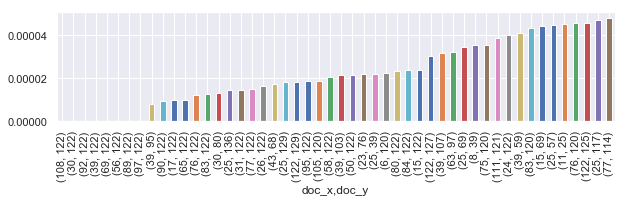

In [46]:
P.cosine.sort_values().head(50).plot(kind='bar', figsize=(10,2 ))

In [47]:
P.cosine.reset_index().to_csv('moby-chapter-pairs.csv', index=False)

## Compare Euclidean and Cosine metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


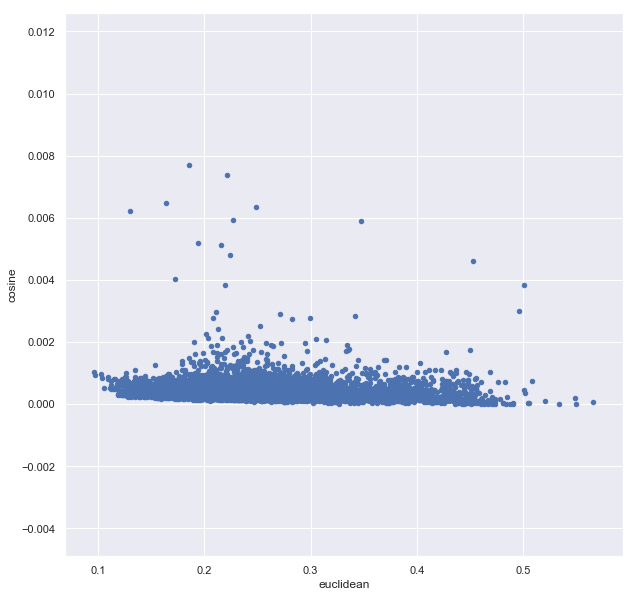

In [48]:
P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10))

In [49]:
P[P.euclidean > .8]

,,euclidean,cosine
doc_x,doc_y,,


## See most similar chapters

In [50]:
P.cosine.sort_values(ascending=False)

doc_x  doc_y
18     22       7.695692e-03
9      83       7.390550e-03
16     18       6.460932e-03
125    129      6.346351e-03
16     22       6.229682e-03
93     129      5.930874e-03
43     78       5.898963e-03
20     22       5.180037e-03
93     125      5.126148e-03
18     20       4.806553e-03
121    122      4.601914e-03
16     20       4.029325e-03
112    113      3.836333e-03
25     97       3.816624e-03
120    122      3.007558e-03
126    127      2.953607e-03
15     17       2.894794e-03
120    129      2.825786e-03
19     21       2.781287e-03
31     121      2.762198e-03
89     90       2.725101e-03
40     129      2.513673e-03
       93       2.412246e-03
110    127      2.242489e-03
40     125      2.178957e-03
126    131      2.117208e-03
107    108      2.109984e-03
62     63       2.084541e-03
126    136      2.048465e-03
127    131      2.029894e-03
                    ...     
6      120      2.232963e-05
25     39       2.180215e-05
23     76       2.170237e-05
5

# Save

In [51]:
for db_file_index in range(0, len(db_file_names)): 
    with sqlite3.connect(db_file_names[db_file_index]) as db:
        K_list[db_file_index].to_sql('token', db, if_exists='replace', index=True)
        V_list[db_file_index].to_sql('vocab', db, if_exists='replace', index=True)

# PART 2: ADD TERM FREQUENCIES AND WEIGHTS TO TABLES

In [52]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

## Create DTM


In [53]:
# Create word mask

# Let's filter out stopwords -- another hyperparameter. 
for db_file_index in range(0, len(db_file_names)): 
    WORDS = (K_list[db_file_index].punc == 0) & (K_list[db_file_index].num == 0) & K_list[db_file_index].term_id.isin(V_list[db_file_index][V_list[db_file_index].stop==0].index)

    # Extrct BOW from tokens

    # To extract a bag-of-words model from our tokens table, we apply a simple `groupby()` operation. Note that we can drop in our hyperparameters easily -- CHAPS and 'term_id' and be replaced. We can easily write a function to simplify this process and make it more configurable. 

    BOW = K_list[db_file_index][WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

    ### Convert BOW to DTM

    DTM = BOW.unstack().fillna(0)

    ## ----- Compute Term Frequencies and Weights -----

    ### Compute TF

    alpha = .000001 # We introduce an arbitrary smoothing value
    alpha_sum = alpha * V.shape[0]
    TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

    ### Compute TFIDF

    N_docs = DTM.shape[0]
    V_list[db_file_index]['df'] = DTM[DTM > 0].count()
    TFIDF = TF * np.log2(N_docs / V_list[db_file_index][V_list[db_file_index].stop==0]['df'])

    ### Compute TFTH (Experiment)

    THM = -(TF * np.log2(TF))
    TFTH = TF.apply(lambda x: x * THM.sum(), 1)

    ### Add stats to V

    V_list[db_file_index]['tf_sum'] = TF.sum()
    V_list[db_file_index]['tf_mean'] = TF.mean()
    V_list[db_file_index]['tf_max'] = TF.max()
    V_list[db_file_index]['tfidf_sum'] = TFIDF.sum()
    V_list[db_file_index]['tfidf_mean'] = TFIDF.mean()
    V_list[db_file_index]['tfidf_max'] = TFIDF.max()
    V_list[db_file_index]['tfth_sum'] = TFTH.sum()
    V_list[db_file_index]['tfth_mean'] = TFTH.mean()
    V_list[db_file_index]['tfth_max'] = TFTH.max()
    V_list[db_file_index]['th_sum'] = THM.sum()
    V_list[db_file_index]['th_mean'] = THM.mean()
    V_list[db_file_index]['th_max'] = THM.max()

    ## Create Docs table

    D = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
    D['tf'] = D.term_count / D.term_count.sum()

    ## Get all doc pairs

    chap_ids = D.index.tolist()
    pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]
    P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
    P.index.names = ['doc_x','doc_y']

    ## Compute Euclidean distance

    P['euclidean'] = 0
    P['euclidean'] = P.apply(euclidean, 1)

    ## Compute Cosine similarity

    P['cosine'] = P.apply(cosine, 1)
    
    # Save data
    
    with sqlite3.connect(db_file_names[db_file_index]) as db:
        V_list[db_file_index].to_sql('vocab', db, if_exists='replace', index=True)
        K_list[db_file_index].to_sql('token', db, if_exists='replace', index=True)
        D.to_sql('doc', db, if_exists='replace', index=True)
        P.to_sql('docpair', db, if_exists='replace', index=True)
    #     BOW.to_frame().rename(columns={'term_id':'n'}).to_sql('bow', db, if_exists='replace', index=True)
        TFIDF.stack().to_frame().rename(columns={0:'term_weight'})\
            .to_sql('dtm_tfidf', db, if_exists='replace', index=True)